In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib

In [2]:
df_first1 = pd.read_csv('bitcamp1.csv')
print((df_first1.shape))

(4857377, 8)


In [3]:

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows





In [5]:
header = None
product_categories = set()
i = 0
line1 = []
T = []

with open('bitcamp1.csv') as file:
    
    
    for line in file:
        if not line.strip():
            continue 
        if not header: 
            header = line.strip().split(',')
            continue
        if 'NaN' in line:
            continue

        line1 = line.strip().split(',')
#         print(line1)
        
        T.append(tuple(line1))
        
        i = i + 1  
        if i == 200000: 
               break
#    print(T)
    final_list =[]
    for k in T:
        empty_list =[]
        for j in k:
            empty_list.append(float(j))
        final_list.append(tuple(empty_list))
#    print(final_list)


        

In [6]:
len(final_list)

200000

In [7]:
conn = create_connection('normalized1b.db')

In [8]:

create_table_sql = """CREATE TABLE HistoryData (
    Timestamp INTEGER NOT NULL PRIMARY KEY,
    Open INTEGER NOT NULL,    
    High INTEGER NOT NULL, 
    Low  INTEGER NOT NULL,
    close INTEGER NOT NULL,
    VolumeBTC INTEGER NOT NULL,
    VolumeCurrency INTEGER NOT NULL,
    WeightedPrice INTEGER NOT NULL
    );
"""
create_table(conn, create_table_sql, drop_table_name='HistoryData')

# def insert_Cty(conn, Values):
#     sql = '''INSERT INTO HistoryData(Timestamp,Open,High,Low,Volume_(BTC),Volume_(Currency),Weighted_Price)
#              Values(?,?,?,?,?,?,?)'''  
#     cur = conn.cursor()
#     cur.execute(sql, Values)
#     return cur.lastrowid

# with conn:
#     for i in final_list:     
#         insert_Cty(conn,i)

with conn:
        cur = conn.cursor()
        cur.executemany("INSERT INTO HistoryData(Timestamp,Open,High,Low,close,VolumeBTC,VolumeCurrency,WeightedPrice) Values(?,?,?,?,?,?,?,?)", final_list)
        
        

In [9]:
sql_statement = "select Timestamp, close, round(avg(close) over(order by Timestamp ROWS BETWEEN 10 PRECEDING AND CURRENT ROW), 2) as SMA1, round(avg(close) over(order by Timestamp ROWS BETWEEN 60 PRECEDING AND CURRENT ROW), 2) as sma2, CASE WHEN round(avg(close) over(order by Timestamp ROWS BETWEEN 10 PRECEDING AND CURRENT ROW), 2)>round(avg(close) over(order by Timestamp ROWS BETWEEN 60 PRECEDING AND CURRENT ROW), 2) THEN 1.0 ELSE 0.0 END AS signal from HistoryData"

std = execute_sql_statement(sql_statement, conn)

In [10]:
create_table_sql = """CREATE TABLE Target (
    Timestamp INTEGER NOT NULL PRIMARY KEY,
    close INTEGER NOT NULL,
    SMA1 INTEGER NOT NULL,
    SMA2 INTEGER NOT NULL,
    SIGNAL INTEGER
    );
"""
create_table(conn, create_table_sql, drop_table_name='Target')

with conn:
        cur = conn.cursor()
        cur.executemany("INSERT INTO Target(Timestamp,close,SMA1,SMA2,SIGNAL) Values(?,?,?,?,?)", std)

In [11]:
query1='''SELECT * FROM  Target'''
df_Table1=pd.read_sql_query(query1,conn)
query2='''SELECT * FROM  HistoryData'''
df_table2=pd.read_sql_query(query2,conn)

In [12]:
df_Table1.head()

,Timestamp,close,SMA1,SMA2,SIGNAL
0,1325317920,4.39,4.39,4.39,0
1,1325346600,4.39,4.39,4.39,0
2,1325350740,4.57,4.45,4.45,0
3,1325350800,4.58,4.48,4.48,0
4,1325391360,4.58,4.50,4.50,0


In [13]:
dataset = pd.concat([df_table2, df_Table1], axis=1)
dataset.head()

,Timestamp,Open,High,Low,close,VolumeBTC,VolumeCurrency,WeightedPrice,Timestamp,close,SMA1,SMA2,SIGNAL
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,1325317920,4.39,4.39,4.39,0
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,1325346600,4.39,4.39,4.39,0
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,1325350740,4.57,4.45,4.45,0
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,1325350800,4.58,4.48,4.48,0
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,1325391360,4.58,4.50,4.50,0


In [14]:
dataset['SIGNAL'].unique()

array([0, 1])

############## Model BUilding- MACHINE LEARNING ALGORITHM ############## 

In [15]:
dataset = dataset.loc[:,~dataset.columns.duplicated()]  # removing column duplicates
del dataset['Timestamp']   # tme stamp column not required

In [16]:
## Outliers

<AxesSubplot:>

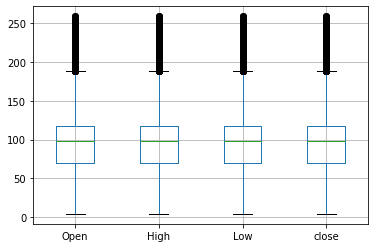

In [17]:
import matplotlib.pyplot as plt
dataset.boxplot(column=['Open','High','Low','close'])#,'VolumeBTC','VolumeCurrency','WeightedPrice'])

In [18]:
## Correlation Matrix

In [19]:

dataset.head()

,Open,High,Low,close,VolumeBTC,VolumeCurrency,WeightedPrice,SMA1,SMA2,SIGNAL
0,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,4.39,4.39,0
1,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,4.39,4.39,0
2,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,4.45,4.45,0
3,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,4.48,4.48,0
4,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,4.50,4.50,0


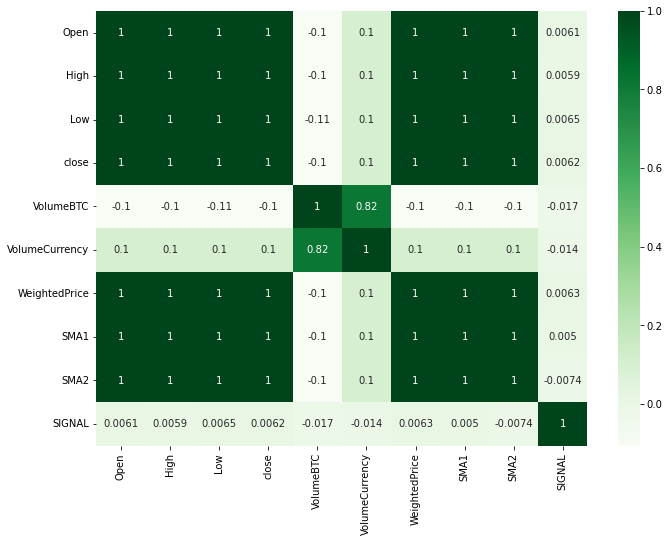

In [20]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

corr = dataset.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

## that's why only close price is choosen for moving avergae concept

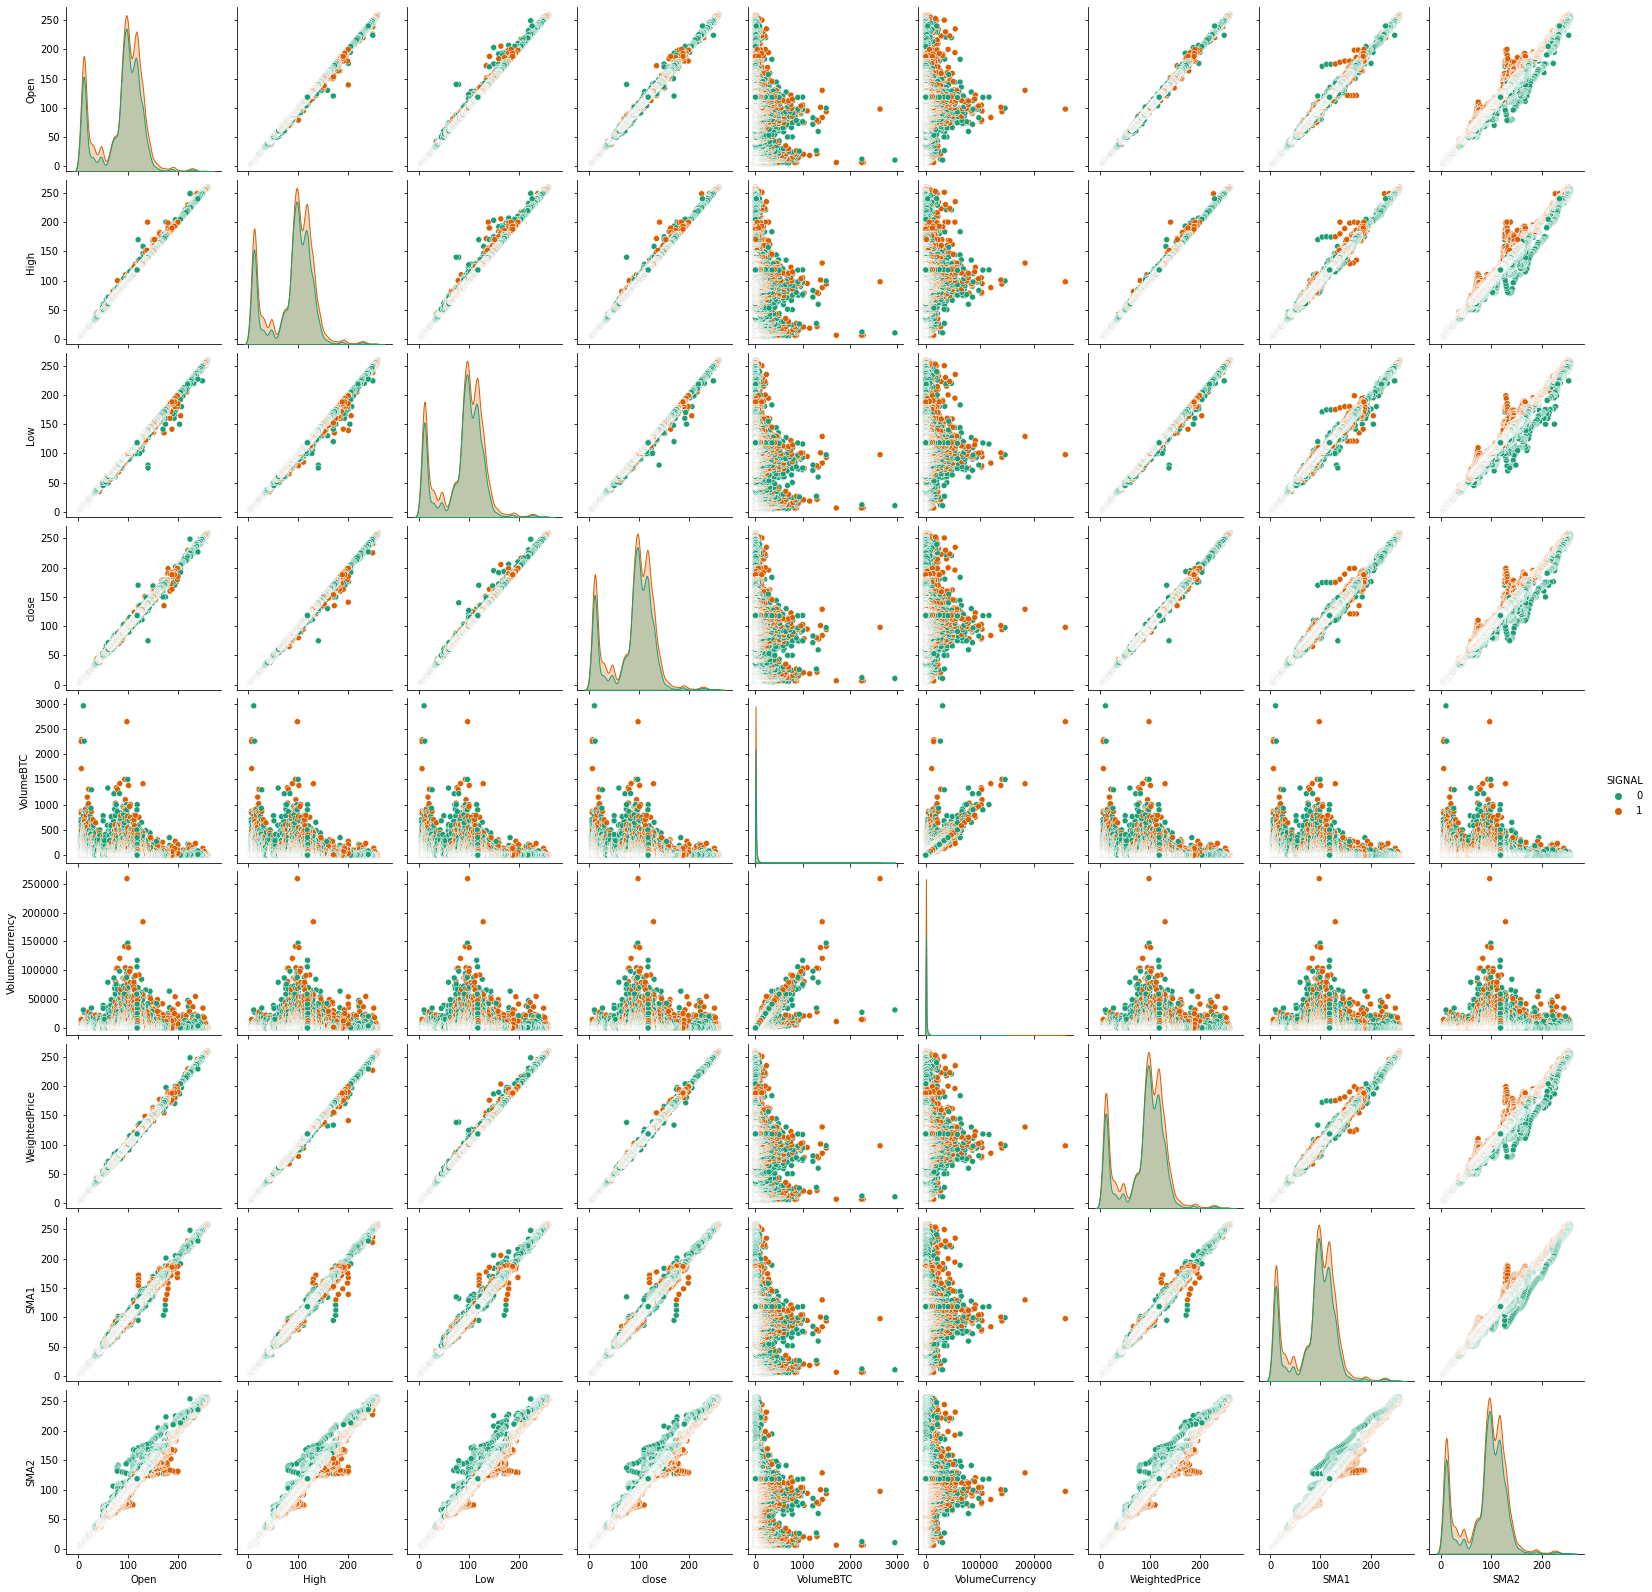

In [21]:
import seaborn as sns
sns.pairplot(dataset,hue='SIGNAL',palette='Dark2')

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## SVM Cassifier 

In [23]:
## Before Tuning

In [24]:
x = dataset[['Open','High','Low','close','VolumeBTC','VolumeCurrency','WeightedPrice','SMA1','SMA2']]
y = dataset[['SIGNAL']]
print(x)
print(y)

          Open    High     Low   close  VolumeBTC  VolumeCurrency  \
0         4.39    4.39    4.39    4.39   0.455581        2.000000   
1         4.39    4.39    4.39    4.39  48.000000      210.720000   
2         4.50    4.57    4.50    4.57  37.862297      171.380338   
3         4.58    4.58    4.58    4.58   9.000000       41.220000   
4         4.58    4.58    4.58    4.58   1.502000        6.879160   
...        ...     ...     ...     ...        ...             ...   
199995  118.20  118.20  118.19  118.19   2.403150      284.043849   
199996  118.19  118.19  118.19  118.19   0.400000       47.276000   
199997  118.19  118.19  118.19  118.19   0.119903       14.171375   
199998  118.19  118.19  118.19  118.19   0.324889       38.398640   
199999  118.19  118.19  118.19  118.19   0.223285       26.390000   

        WeightedPrice    SMA1    SMA2  
0            4.390000    4.39    4.39  
1            4.390000    4.39    4.39  
2            4.526411    4.45    4.45  
3          

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#scaler.fit(x)
x= pd.DataFrame(scaler.fit_transform(x))
x = np.asarray(x)
y = np.asarray(y)
print(x)
print(y)

[[-1.92420441 -1.92421651 -1.92441547 ... -1.92433566 -1.92449979
  -1.92453542]
 [-1.92420441 -1.92421651 -1.92441547 ... -1.92433566 -1.92449979
  -1.92453542]
 [-1.92166915 -1.92007201 -1.92187681 ... -1.92119107 -1.92311649
  -1.92315186]
 ...
 [ 0.69863085  0.69602631  0.7019457  ...  0.69901014  0.70238659
   0.70884164]
 [ 0.69863085  0.69602631  0.7019457  ...  0.69901014  0.70123384
   0.70861105]
 [ 0.69863085  0.69602631  0.7019457  ...  0.69901014  0.70123384
   0.70838045]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [26]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=1,shuffle=True)

In [27]:
model=SVC()
model.fit(x_train,y_train)
predict=model.predict(x_test)
accuracy_score(y_test,predict)

/Users/akhilreddykatha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.770675

In [28]:
parameters = {'kernel':('linear', 'rbf','poly', 'sigmoid'), 'C':[1, 10]}

In [29]:
grid = GridSearchCV(SVC(),parameters)
grid.fit(x_train,y_train)
#print(grid.best_estimator_)

/Users/akhilreddykatha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/akhilreddykatha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/akhilreddykatha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/akhilreddykatha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1

In [ ]:
grid_predictions = grid.predict(x_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))


[[ 752   59]
 [   4 1185]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       811
           1       0.95      1.00      0.97      1189

    accuracy                           0.97      2000
   macro avg       0.97      0.96      0.97      2000
weighted avg       0.97      0.97      0.97      2000



# KNN Classifier

In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Training the K-NN model on the Training set

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


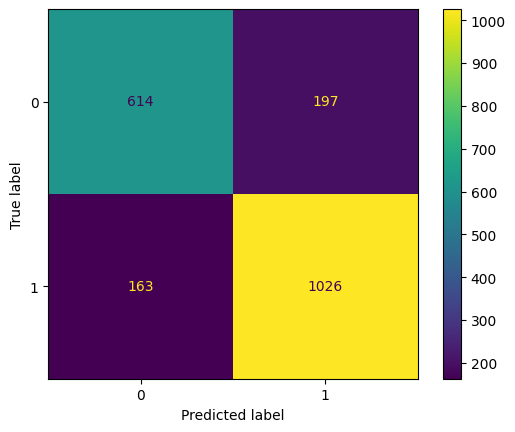

In [ ]:
plot_confusion_matrix(classifier, x_test, y_test) 

In [ ]:
accuracy_score(y_test, y_pred)

0.82

<h1>Random Forest Classification</h1>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier3 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)
classifier3.fit(x_train, y_train)
y_pred = classifier3.predict(x_test)

/var/folders/rh/24nstj9d1jggx63sqd127qwh0000gn/T/ipykernel_36499/2267071737.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier3.fit(x_train, y_train)


/var/folders/rh/24nstj9d1jggx63sqd127qwh0000gn/T/ipykernel_36499/174110763.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier3.fit(x_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1)

In [ ]:
y_pred = classifier3.predict(x_test)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.95215


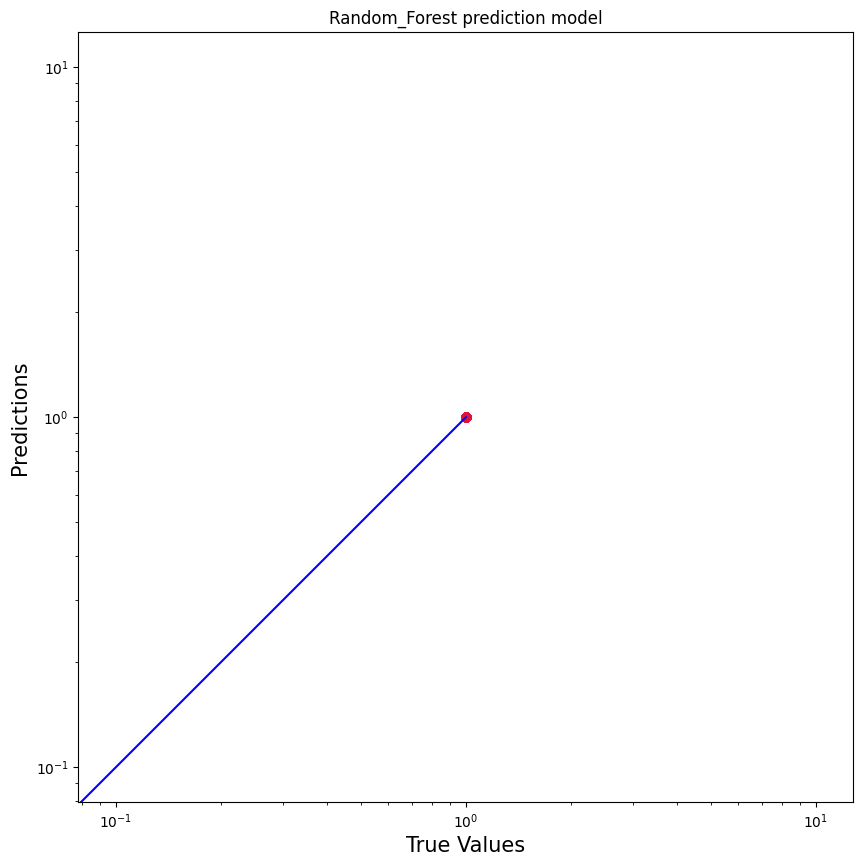

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))

plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Random_Forest prediction model')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# THE END